<a href="https://colab.research.google.com/github/abubakrsiddq/ImageDehazing/blob/main/models/LCA-net/lca_kitti.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import random
from PIL import Image
import time
import datetime
import keras

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.optimizers import Adam



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data loader Pipeline

In [3]:
def load_image(img_path):
    img = tf.io.read_file(img_path)
    
    img = tf.io.decode_png(img, channels = 3)
    img = tf.image.resize(img, size = (352 , 1216), antialias = True)
    img = img / 255.0
    return img

In [4]:
def dataset_preposses(orig_img_path='/content/drive/MyDrive/generated_dataset/trans',hazy_img_path='/content/drive/MyDrive/generated_dataset/hazy',percentage=0.1,validation_size=200,test_size=64,seed_val=200):
    train_img = []
    val_img = []
    random.seed=seed_val
    orig_img = glob.glob(orig_img_path + '/*.png')
    n = len(orig_img)
    random.shuffle(orig_img)
    red_keys=orig_img[:]                                 #redundant keys to avoid key error
    train_keys = orig_img[:int(0.9*n*percentage)]
    #print(0.9*n*percentage)
    #print(len(train_keys))
    val_keys = orig_img[-int(0.1*n*percentage):]
    #print(len(val_keys))
    split_dict = {}
    #i=0
    for key in red_keys:
      split_dict[key]='red'
      #i+=1
    #print(i)
    for key in train_keys:
      split_dict[key] = 'train'
    for key in val_keys:
      split_dict[key] = 'val'
      
    hazy_img = glob.glob(hazy_img_path + '/*.png')
    for img in hazy_img:
      
      img_name = img.split('/')[-1][:-4].split('_')[0]
      orig_path = orig_img_path + '/' + img_name+'.png'
      if (split_dict[orig_path] == 'train'):
        train_img.append([img, orig_path])
      if (split_dict[orig_path] == 'val'):
        val_img.append([img, orig_path])
      

    return train_img, val_img


def gen_dataset(ar):
  '''
  parameters
  list of paths
  return
  list with gt attached 
  '''
  orig_path='/content/drive/MyDrive/kitti/gt'
  haze_pth='/content/drive/MyDrive/kitti/hazy'
  lst=[]
  for i in ar:
    name=i.split('/')[-1].split('_')[0]
    pthlist=[i,orig_path+'/'+name+'.jpg']
    lst.append(pthlist)
  return lst

def data_path(orig_img_path = '/content/drive/MyDrive/kitti/gt', hazy_img_path = '/content/drive/MyDrive/kitti/hazy'):
  
  (a,b,c)=dataset_preposses(orig_path=orig_img_path,haze_path=hazy_img_path)
  a=gen_dataset(a)
  b=gen_dataset(b)
  return a,b

In [5]:
def dataloader(train_data, val_data, batch_size):
    print(len(train_data))
    train_data_orig = tf.data.Dataset.from_tensor_slices([img[1] for img in train_data]).map(lambda x: load_image(x))
    train_data_haze = tf.data.Dataset.from_tensor_slices([img[0] for img in train_data]).map(lambda x: load_image(x))
    train = tf.data.Dataset.zip((train_data_haze, train_data_orig)).shuffle(buffer_size=100).batch(batch_size)
    
    val_data_orig = tf.data.Dataset.from_tensor_slices([img[1] for img in val_data]).map(lambda x: load_image(x))
    val_data_haze = tf.data.Dataset.from_tensor_slices([img[0] for img in val_data]).map(lambda x: load_image(x))
    val = tf.data.Dataset.zip((val_data_haze, val_data_orig)).shuffle(buffer_size=100).batch(batch_size)
    
    return train, val

In [6]:
def display_img(model, hazy_img, orig_img):
    
    dehazed_img = model(hazy_img,0,training = False)
    plt.figure(figsize = (15,15))
    
    display_list = [hazy_img[0], orig_img[0], dehazed_img[0]]
    title = ['Hazy Image', 'Ground Truth', 'Dehazed Image']
    
    for i in range(3):
        plt.subplot(3, 1, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
        directory='/content/drive/MyDrive/Test/padCheck'
        os.chdir(directory)
        filename=str(i)+'.jpg'
        tf.keras.preprocessing.image.save_img(filename,display_list[i],)
        #plt.imsave('plt'+filename,display_list[i])
    plt.show()

## Model

In [7]:
def LCAnet():
    
    inputs = tf.keras.Input(shape = [352,1216, 3])     # height, width of input image changed because of error in output
    conv = Conv2D(filters = 50, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu',)(inputs)
    poolLayer=AveragePooling2D(pool_size=(2,2))(conv)
    conv1 = Conv2D(filters = 50, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')(poolLayer)
    poolLayer=AveragePooling2D(pool_size=(2,2))(conv1)  
    #flat=Flatten()(poolLayer)
    dens1=Dense(10,activation='relu')(poolLayer)
    dens2=Dense(10,activation='relu')(dens1)
    deconv1=Conv2DTranspose(50,kernel_size=(3,3),padding='same',activation='relu')(dens2)
    upsamp1=UpSampling2D(size=(2,2))(deconv1)
    deconv2=Conv2DTranspose(50,kernel_size=(3,3),padding='same',activation='relu')(upsamp1)
    upsamp2=UpSampling2D(size=(2,2))(deconv2)
    deconv3=Conv2DTranspose(3,kernel_size=(3,3),padding='same',activation='linear')(upsamp2)
    output = deconv3
    
    return Model(inputs = inputs, outputs = output)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 352, 1216, 3)]    0         
_________________________________________________________________
conv2d (Conv2D)              (None, 352, 1216, 50)     1400      
_________________________________________________________________
average_pooling2d (AveragePo (None, 176, 608, 50)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 176, 608, 50)      22550     
_________________________________________________________________
average_pooling2d_1 (Average (None, 88, 304, 50)       0         
_________________________________________________________________
dense (Dense)                (None, 88, 304, 10)       510       
_________________________________________________________________
dense_1 (Dense)              (None, 88, 304, 10)       110   

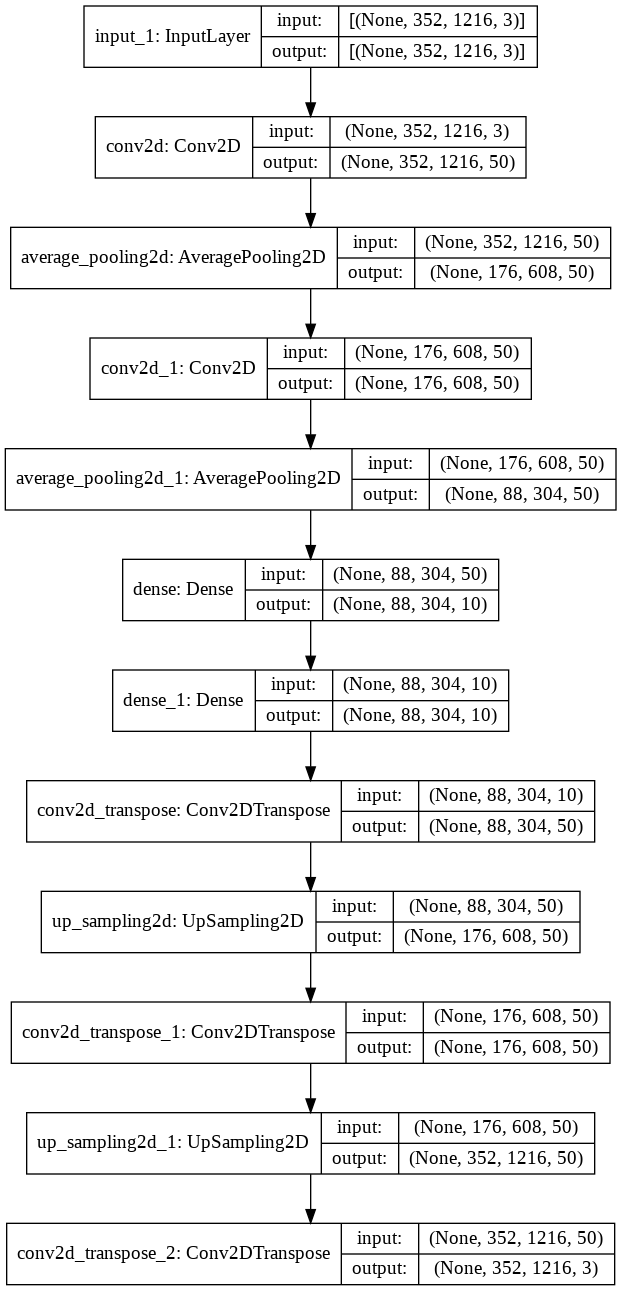

In [8]:
model=LCAnet()
model.load_weights('/content/drive/MyDrive/kitti_nets/lca/weights/')
model.build([352,1216,3])
model.summary()

dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [9]:
# Hyperparameters
epochs = 10

k_init = tf.keras.initializers.random_normal(stddev=0.008, seed = 101)      
regularizer = tf.keras.regularizers.L2(1e-4)
b_init = tf.constant_initializer()
batch_size=2
train_data, val_data = dataset_preposses(orig_img_path = '/content/drive/MyDrive/kitti/gt', hazy_img_path = '/content/drive/MyDrive/kitti/hazy',percentage=0.05)
train, val = dataloader(train_data, val_data, batch_size)

optimizer = Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.99)
train_loss_tracker = tf.keras.metrics.MeanSquaredError(name = "train loss")
val_loss_tracker = tf.keras.metrics.MeanSquaredError(name = "val loss")

270


In [12]:
def train_model(epochs, train, val,net,train_loss_tracker,val_loss_tracker, optimizer):
    
    for epoch in range(epochs):
        
        print("\nStart of epoch %d" % (epoch,), end=' ')
        start_time_epoch = time.time()
        start_time_step = time.time()
        
        # training loop
        
        for step, (train_batch_haze, train_batch_orig) in enumerate(train):

            with tf.GradientTape() as tape:

                #train_logits = net(train_batch_haze,train_batch_orig,training = True)
                #t=t_net(train_batch_haze)
                #a=a_net(train_batch_haze)
                #out=tf.add(tf.multiply(train_batch_orig,t),tf.multiply(a,(1-t)))
                train_logits=net(train_batch_haze)
                #loss = mean_squared_error(train_batch_haze,train_logits)
                loss = mean_squared_error(train_batch_orig,train_logits)
                #loss=tf.math.reduce_mean(loss,axis=None)
                #er=tf.keras.losses.MeanAbsoluteError(tf.keras.losses.Reduction.AUTO)
                #loss=er(train_batch_orig, train_logits)/batch_size
                #loss=tf.image.psnr(train_batch_orig, train_logits, max_val=1)
                #loss=tf.image.ssim(train_batch_orig, train_logits, max_val=1, filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03)
                #loss=custom_loss(train_batch_haze,out)
                #loss=tf.math.reduce_mean(loss)
                #print(loss)

            grads = tape.gradient(loss,net.trainable_weights)
            #grads2 = tape.gradient(loss,a_net.trainable_weights)
            #optimizer.apply_gradients(zip(grads, t_net.trainable_weights))
            optimizer.apply_gradients(zip(grads, net.trainable_weights))

            train_loss_tracker.update_state(train_batch_orig, train_logits)
            if step == 0:
                print('[', end='')
            if step % 256 == 0:
                print('=', end='')
        
        print(']', end='')
        print('  -  ', end='')
        print('Training Loss: %.4f' % (train_loss_tracker.result()), end='')
        
        # validation loop
        
        for step, (val_batch_haze, val_batch_orig) in enumerate(val):
            val_logits = net(val_batch_haze)
            val_loss_tracker.update_state(val_batch_orig, val_logits)
            
            if step % 256 ==0:
                display_img(net, val_batch_haze, val_batch_orig)
        
        print('  -  ', end='')
        print('Validation Loss: %.4f' % (val_loss_tracker.result()), end='')
        print('  -  ', end=' ')
        print("Time taken: %.2fs" % (time.time() - start_time_epoch))
        
        #net.save('trained_model')           # save the model(variables, weights, etc)
        train_loss_tracker.reset_states()
        val_loss_tracker.reset_states()

In [13]:
%%time
train_model(1, train, val,model,train_loss_tracker, val_loss_tracker,optimizer )


Start of epoch 0 [=

KeyboardInterrupt: ignored

In [14]:
model.save('/content/drive/MyDrive/kitti_nets/lca/')
model.save_weights('/content/drive/MyDrive/kitti_nets/lca/weights/')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/kitti_nets/lca/assets


In [ ]:
import cv2
import matplotlib.pyplot as plt

def evaluate_gen(net):
    
    #test_img = glob.glob(test_img_path +'/*.jpg')
    test_img=glob.glob('/content/drive/MyDrive/test_set/hazy/*.png')
    #random.shuffle(test_img)
    i=0;
    for img in test_img:
        
        img = tf.io.read_file(img)
        img = tf.io.decode_png(img, channels = 3)
        
        img = tf.image.resize(img, size = (352,1216), antialias = True)
        
        img = img / 255.0
        print(i,end=" ")
        img = tf.expand_dims(img, axis = 0)      #transform input image from 3D to 4D ###
        
        dehaze = net(img)
        
        #plt.figure(figsize = (80, 80))
        
        #display_list = [img[0], dehaze[0]]       #make the first dimension zero
        im=dehaze[0]
        #im=((dehaze[0]-0.4)/0.2)*255
        #print(im.numpy().min())
        directory = '/content/drive/MyDrive/test_set/lca/'
        os.chdir(directory)
        filename = str(i) + '_outdoor_gen.png'
        #print(filename)
        #cv2.imwrite(filename,im) 
        #plt.imsave(filename,im)
        tf.keras.preprocessing.image.save_img(
    filename, im)

        os.chdir('/content')
        i+=1;
        

In [ ]:
evaluate_gen(model)